In [1]:
import plotly.express as px
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit # Numerically stable sigmoid function

# Import Data

# Set print options to suppress scientific notation
np.set_printoptions(suppress=True)

year = 2014
period = ['may-jun', 'jun-jul']

# Import data
if year == 2014:
    X = np.load('../data/processed/data_2014.npz')

elif year == 2015:
    X = np.load('../data/processed/data_2015.npz')

elif year == 2016:
    X = np.load('../data/processed/data_2016.npz')
    
elif year == 2017:
    X = np.load('../data/processed/data_2017.npz')

N = X['N']

dist = X['distance']
#tI1 = X['tI1'].reshape(N,1)
#tI2 = X['tI2'].reshape(N,1)
sI2 = X['sI2'].reshape(N,1)

y_apr = X['y_apr'].reshape(N,1)
y_may = X['y_may'].reshape(N,1)
y_jun = X['y_jun'].reshape(N,1)
y_jul = X['y_jul'].reshape(N,1)

n_apr = X['n_apr'].reshape(N,1)
n_may = X['n_may'].reshape(N,1)
n_jun = X['n_jun'].reshape(N,1)
n_jul = X['n_jul'].reshape(N,1)

a_apr = X['a_apr'].reshape(N,1)
a_may = X['a_may'].reshape(N,1)
a_jun = X['a_jun'].reshape(N,1)
a_jul = X['a_jul'].reshape(N,1)

w_apr = X['wind_apr']
w_may = X['wind_may']
w_jun = X['wind_jun']
w_jul = X['wind_jul']

sI1_apr = X['sI1_apr'].reshape(N,1)
sI1_may = X['sI1_may'].reshape(N,1)
sI1_jun = X['sI1_jun'].reshape(N,1)
sI1_jul = X['sI1_jul'].reshape(N,1)

s_apr = X['s_apr'].reshape(N,1)
s_may = X['s_may'].reshape(N,1)
s_jun = X['s_jun'].reshape(N,1)
s_jul = X['s_jul'].reshape(N,1)

# Convert to float64
dist = dist.astype(np.float64)
#tI1 = tI1.astype(np.float64)
#tI2 = tI2.astype(np.float64)
sI2 = sI2.astype(np.float64)

y_apr = y_apr.astype(np.float64)
y_may = y_may.astype(np.float64)
y_jun = y_jun.astype(np.float64)
y_jul = y_jul.astype(np.float64)

n_apr = n_apr.astype(np.float64)
n_may = n_may.astype(np.float64)
n_jun = n_jun.astype(np.float64)
n_jul = n_jul.astype(np.float64)

a_apr = a_apr.astype(np.float64)
a_may = a_may.astype(np.float64)
a_jun = a_jun.astype(np.float64)
a_jul = a_jul.astype(np.float64)

w_apr = w_apr.astype(np.float64)
w_may = w_may.astype(np.float64)
w_jun = w_jun.astype(np.float64)
w_jul = w_jul.astype(np.float64)

sI1_apr = sI1_apr.astype(np.float64)
sI1_may = sI1_may.astype(np.float64)
sI1_jun = sI1_jun.astype(np.float64)
sI1_jul = sI1_jul.astype(np.float64)

s_apr = s_apr.astype(np.float64)
s_may = s_may.astype(np.float64)
s_jun = s_jun.astype(np.float64)
s_jul = s_jul.astype(np.float64)


# Function to normalize the data
def norm(x):
    
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalize the data
dist = norm(dist)

a_apr = norm(a_apr)
a_may = norm(a_may)
a_jun = norm(a_jun)
a_jul = norm(a_jul)


# Import Paramaters

if year == 2014:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2014_SLSQP.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2014_SLSQP.npy', allow_pickle=True)
    
elif year == 2015:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2015.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2015.npy', allow_pickle=True)
    
elif year == 2016:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2016.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2016.npy', allow_pickle=True)
    
elif year == 2017:
    
    theta_may_jun = np.load('../reports/parameters/theta_may-jun_2017_1_1.npy', allow_pickle=True)
    theta_jun_jul = np.load('../reports/parameters/theta_jun-jul_2017_1_1.npy', allow_pickle=True)

# Safe exponential function
def safe_exp(x):
    """Prevent overflow of exponential function."""
    # np.finfo('d').max is the maximum representable positive number
    # np.log(np.finfo('d').max) is the maximum number that can be exponentiated without overflow
    # We clamp x to this range before taking the exponent
    x = np.clip(x, None, np.log(np.finfo('d').max))
    return np.exp(x)

# Define the function eta() which takes input parameters theta and returns the log-odds of disease for each yard i in current time period
def eta(theta, period, y_lag):
    
    y_lag = y_lag
    
    if period == 'may-jun':

        #y_lag = y_may
        n_lag = n_may
        a_lag = a_may
        w_lag = w_may
        #sI1_lag = sI1_may
        s_lag = s_may

    elif period == 'jun-jul':
        
        #y_lag = y_jun
        n_lag = n_jun
        a_lag = a_jun
        w_lag = w_jun
        #sI1_lag = sI1_jun
        s_lag = s_jun
    
    eta = []
    eta_1 = []  
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    
    for i in range(0, N):
    
        auto_infection1 = beta1 + delta1 * (y_lag[i] / n_lag[i]) * np.exp(-eta11 * s_lag[i])
        auto_infection2 = beta2 + delta2 * (y_lag[i] / n_lag[i]) * np.exp(-eta12 * s_lag[i])

        mask = np.arange(N) != i # mask out the current yard i
        
        dispersal_component1 = gamma1 * np.sum(((a_lag[mask] * (y_lag[mask] / n_lag[mask])) * np.exp(-eta21 * s_lag[mask]) * (w_lag[:, i][mask].reshape(N-1, 1) * np.exp(-alpha1 * dist[:, i][mask].reshape(N-1, 1))) * sI1_lag[mask]))
        dispersal_component2 = gamma2 * np.sum(((a_lag[mask] * (y_lag[mask] / n_lag[mask])) * np.exp(-eta22 * s_lag[mask]) * (w_lag[:, i][mask].reshape(N-1, 1) * np.exp(-alpha2 * dist[:, i][mask].reshape(N-1, 1))) * sI2[mask]))
        
        eta_i = tI1[i] * (auto_infection1 + dispersal_component1) + tI2[i] * (auto_infection2 + dispersal_component2)
        eta.append(eta_i)
        
        eta_1_i = tI1[i] * (auto_infection1 + dispersal_component1 - beta1) + tI2[i] * (auto_infection2 + dispersal_component2 - beta2)
        eta_1.append(eta_1_i)
        
    
    eta = np.array(eta).reshape(N,1)
    eta_1 = np.array(eta_1).reshape(N,1)
    
    return eta, eta_1


def eta(theta, period, y_lag):
    
    y_lag = y_lag

    if period == 'may-jun':

        #y_lag = y_may
        n_lag = n_may
        a_lag = a_may
        w_lag = w_may
        #sI1_lag = sI1_may
        s_lag = s_may

    elif period == 'jun-jul':
        
        #y_lag = y_jun
        n_lag = n_jun
        a_lag = a_jun
        w_lag = w_jun
        #sI1_lag = sI1_jun
        s_lag = s_jun
        
    beta1, beta2, delta1, delta2, gamma1, gamma2, alpha1, alpha2, eta11, eta12, eta21, eta22 = theta
    
    beta1_array = np.full((N,1), beta1)
    beta2_array = np.full((N,1), beta2)
    
    auto_infection1 = delta1 * (y_lag / n_lag) * np.exp(-eta11 * s_lag)
    auto_infection2 = delta2 * (y_lag / n_lag) * np.exp(-eta12 * s_lag)
    
    dispersal1 = []
    dispersal2 = []
    
    eta_1 = [] 
    
    for i in range(0, N):
        
        dispersal_array = ((a_lag * (y_lag / n_lag)) * (w_lag[:, i].reshape(N,1)))
        dispersal_array1 = dispersal_array * np.exp(-eta21 * s_lag) * np.exp(-alpha1 * dist[:, i].reshape(N,1)) * sI1_lag
        dispersal_array2 = dispersal_array * np.exp(-eta22 * s_lag) * np.exp(-alpha2 * dist[:, i].reshape(N,1)) * sI2
        dispersal_component1_i = gamma1 * (np.sum(dispersal_array1) - dispersal_array1[i][0])
        dispersal_component2_i = gamma2 * (np.sum(dispersal_array2) - dispersal_array2[i][0])
        
        dispersal1.append(dispersal_component1_i)
        dispersal2.append(dispersal_component2_i)
    
    dispersal1 = np.array(dispersal1).reshape(N,1)
    dispersal2 = np.array(dispersal2).reshape(N,1)
    
    eta = tI1 * (beta1_array + auto_infection1 + dispersal1) + tI2 * (beta2_array + auto_infection2 + dispersal2)
    
    eta_1_i = tI1[i] * (auto_infection1 + dispersal1) + tI2[i] * (auto_infection2 + dispersal2)
    eta_1.append(eta_1_i)
    eta_1 = np.array(eta_1).reshape(N,1)
    
    return eta, eta_1


# Probability Function

def prob(theta, period, y_lag):
    
    etaa = eta(theta, period, y_lag)
    
    p = expit(etaa[0])
    
    for i in range(0, N):
    
        if etaa[1][i] == 0.0:
            
            p[i] = 0.0    
    
    return p

# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

In [3]:
theta_jun_jul

array([[ -2.64383869],
       [ -3.07897399],
       [ 57.19160484],
       [ 32.66357326],
       [101.3930581 ],
       [389.86888937],
       [  5.34867418],
       [ 97.18103767],
       [ 54.98064443],
       [ 86.67070659],
       [  0.27770459],
       [  0.09944729]])

In [2]:
theta_may_jun

array([[  -1.90199427],
       [  -5.89298669],
       [1084.87231619],
       [  98.22151184],
       [ 826.58571766],
       [4190.68361118],
       [  12.36124891],
       [  19.77812373],
       [   3.90317286],
       [   1.55499324],
       [  -0.226496  ],
       [   0.7442895 ]])

In [55]:
s_may[0]

array([1.])

In [57]:
sI1_lag[31]

array([1.])

In [11]:
variety_df.iloc[0]

Susceptibility1    1.0
Susceptibility2    0.0
Variety            1.0
Name: 0, dtype: float64

## Function

$$
\eta_{i}=\sum_{k=1}^{K} I_{k}^{(t)}(i)\left[\beta_{k}+\delta_{k}\left(\frac{\tilde{y}_{i}}{n_{\tilde{y}_{i}}} \exp{\left(-\eta_{1k} s_{i}\right)}\right)+\gamma_{k} \sum_{j=1}^{M_{i}}\left(\frac{a_{j} z_{j}}{n_{z_{j}}} \exp{\left(-\eta_{2k} s_{j}\right)} w_{i j} \exp{\left(-\alpha_{k} d_{i j}\right)} I_{k}^{(s)}(j)\right)\right]
$$

In [70]:
prob(theta_jun_jul, period='jun-jul', y_lag=10*np.ones((N,1)))


array([[0.01903251],
       [0.01953437],
       [0.14667658],
       [0.01655972],
       [0.14061195],
       [0.01909237],
       [0.00290997],
       [0.04154183],
       [0.12259975],
       [0.14900462],
       [0.03850447],
       [0.04289432],
       [0.0431619 ],
       [0.04243713],
       [0.15003204],
       [0.017388  ],
       [0.16247014],
       [0.04332827],
       [0.04067948],
       [0.04102877],
       [0.01938462],
       [0.15402301],
       [0.05572991],
       [0.04959752],
       [0.12643821],
       [0.04095208],
       [0.0548204 ],
       [0.08502979],
       [0.03638116],
       [0.07043463],
       [0.0511452 ],
       [0.05091958],
       [0.09605086],
       [0.06687997],
       [0.01313697],
       [0.08005475],
       [0.0143556 ],
       [0.00419927],
       [0.01271431],
       [0.09007076],
       [0.07272771],
       [0.07228593],
       [0.05639975],
       [0.01217268],
       [0.04551001],
       [0.05319252],
       [0.0538222 ],
       [0.005

In [ ]:
# Estimate y_2, the number of infections in July
y_2 = prob(theta_jun_jul, period='jun-jul', y_lag=y_1) * n

# Simulations

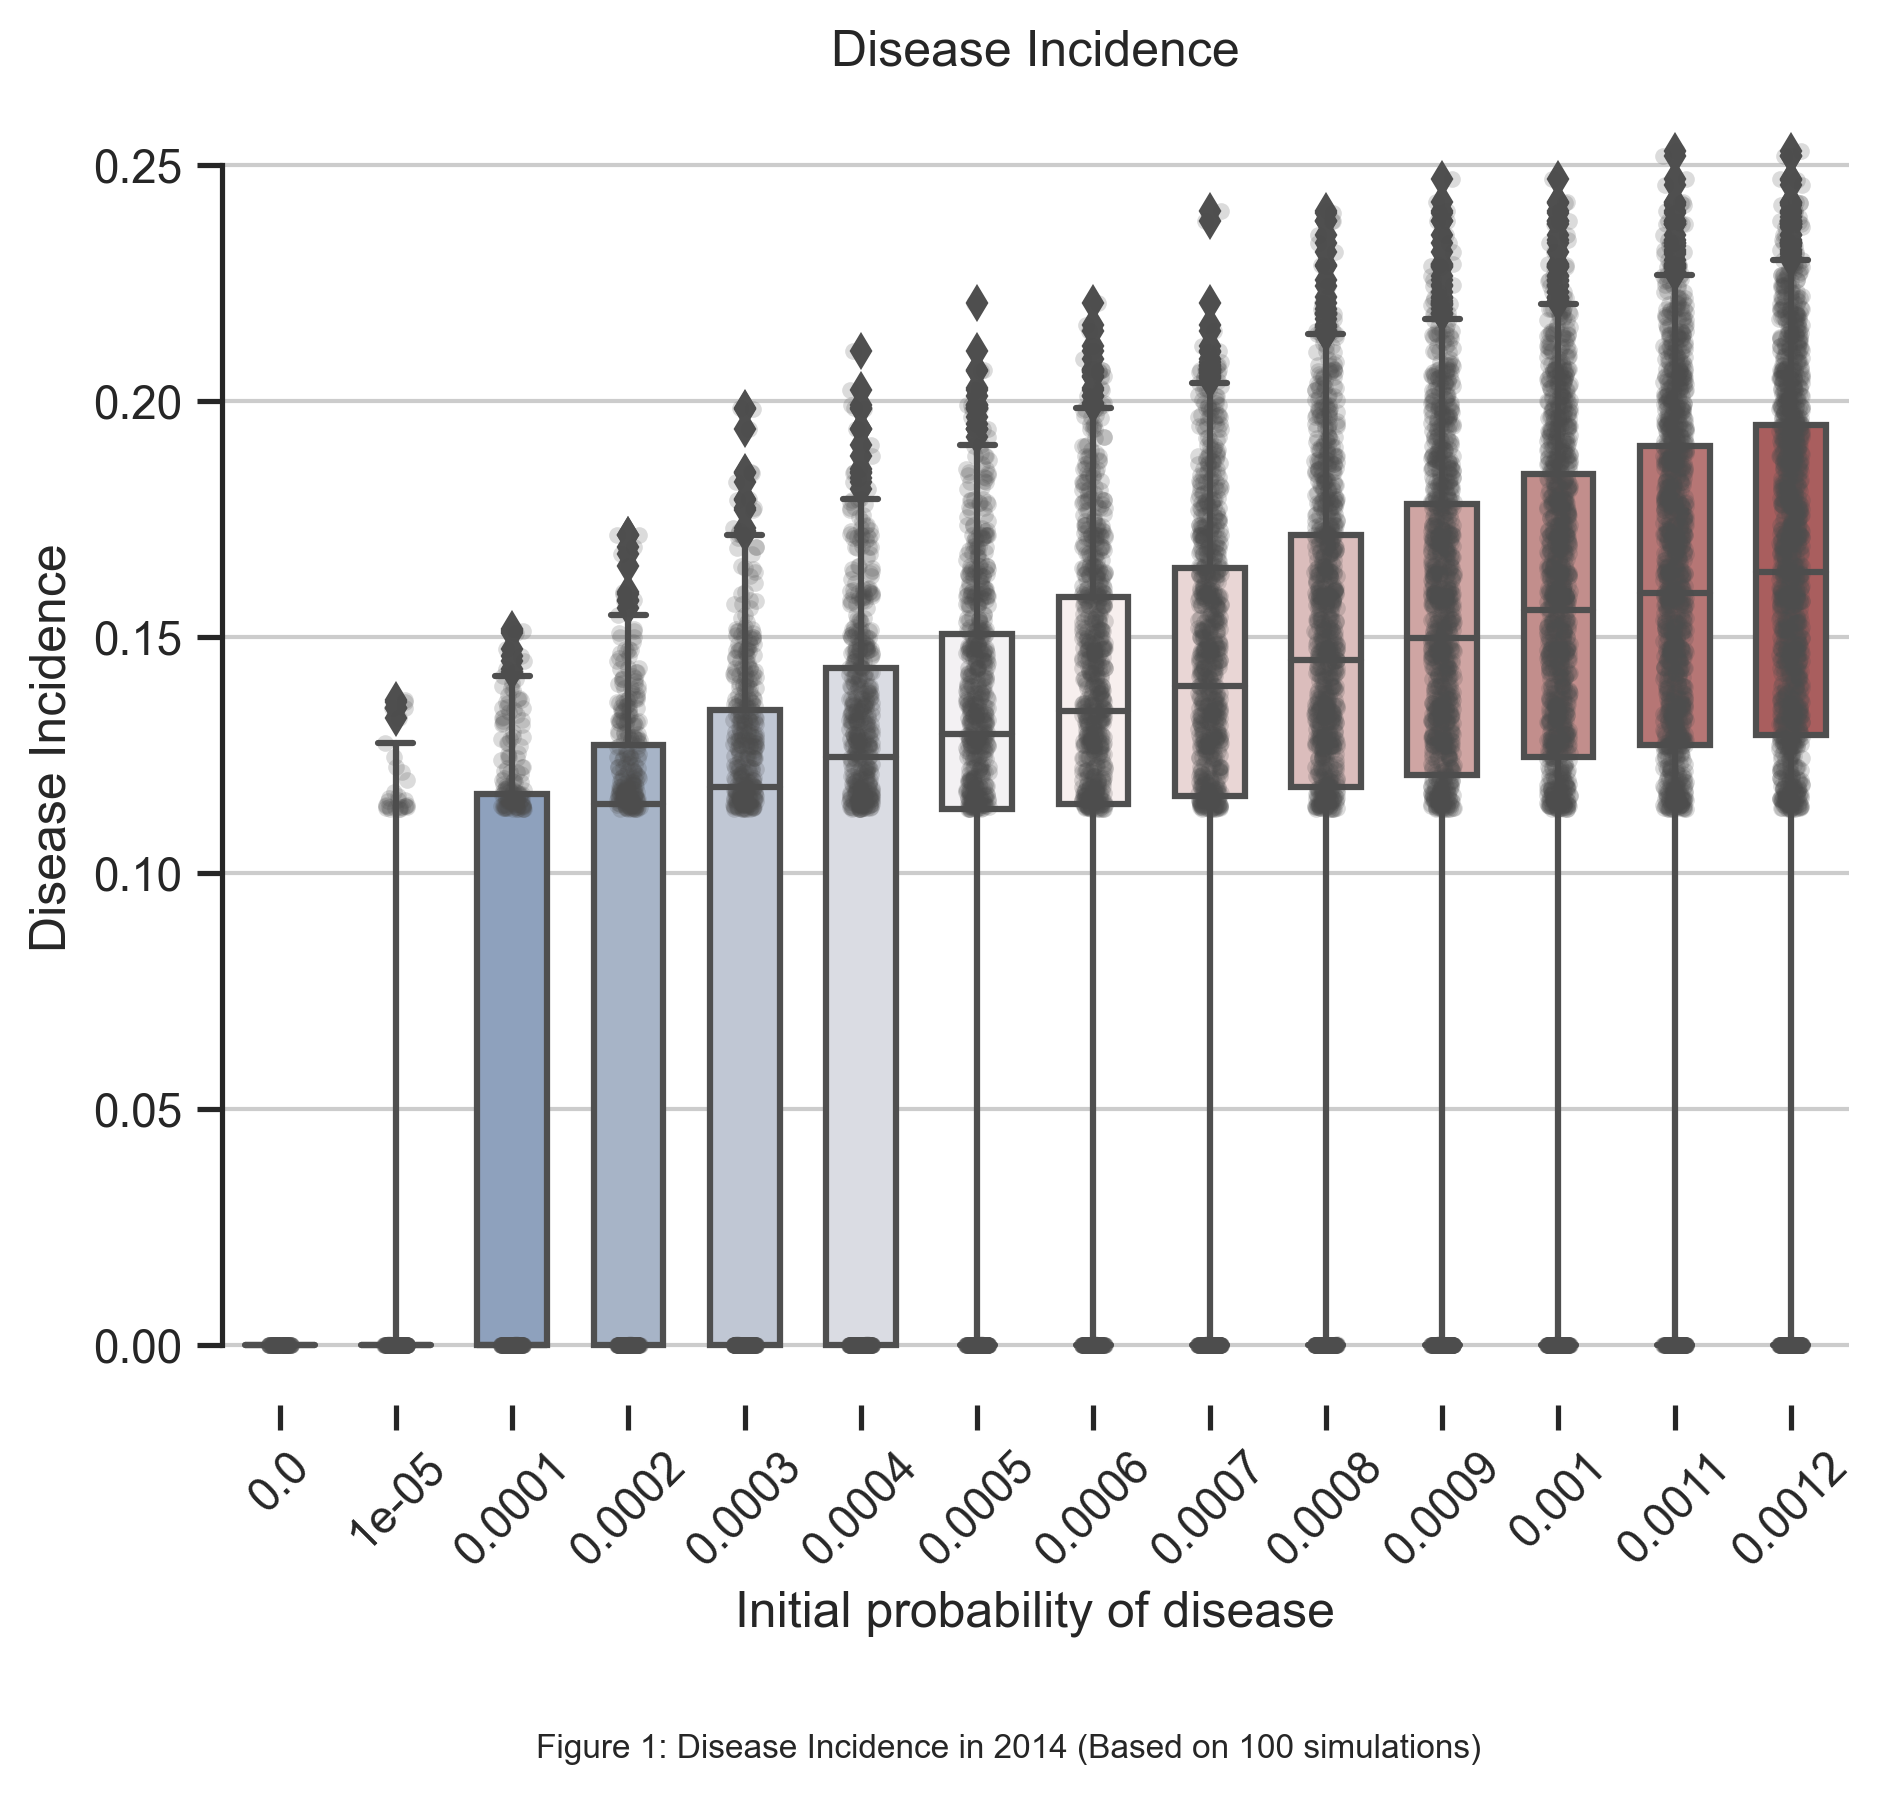

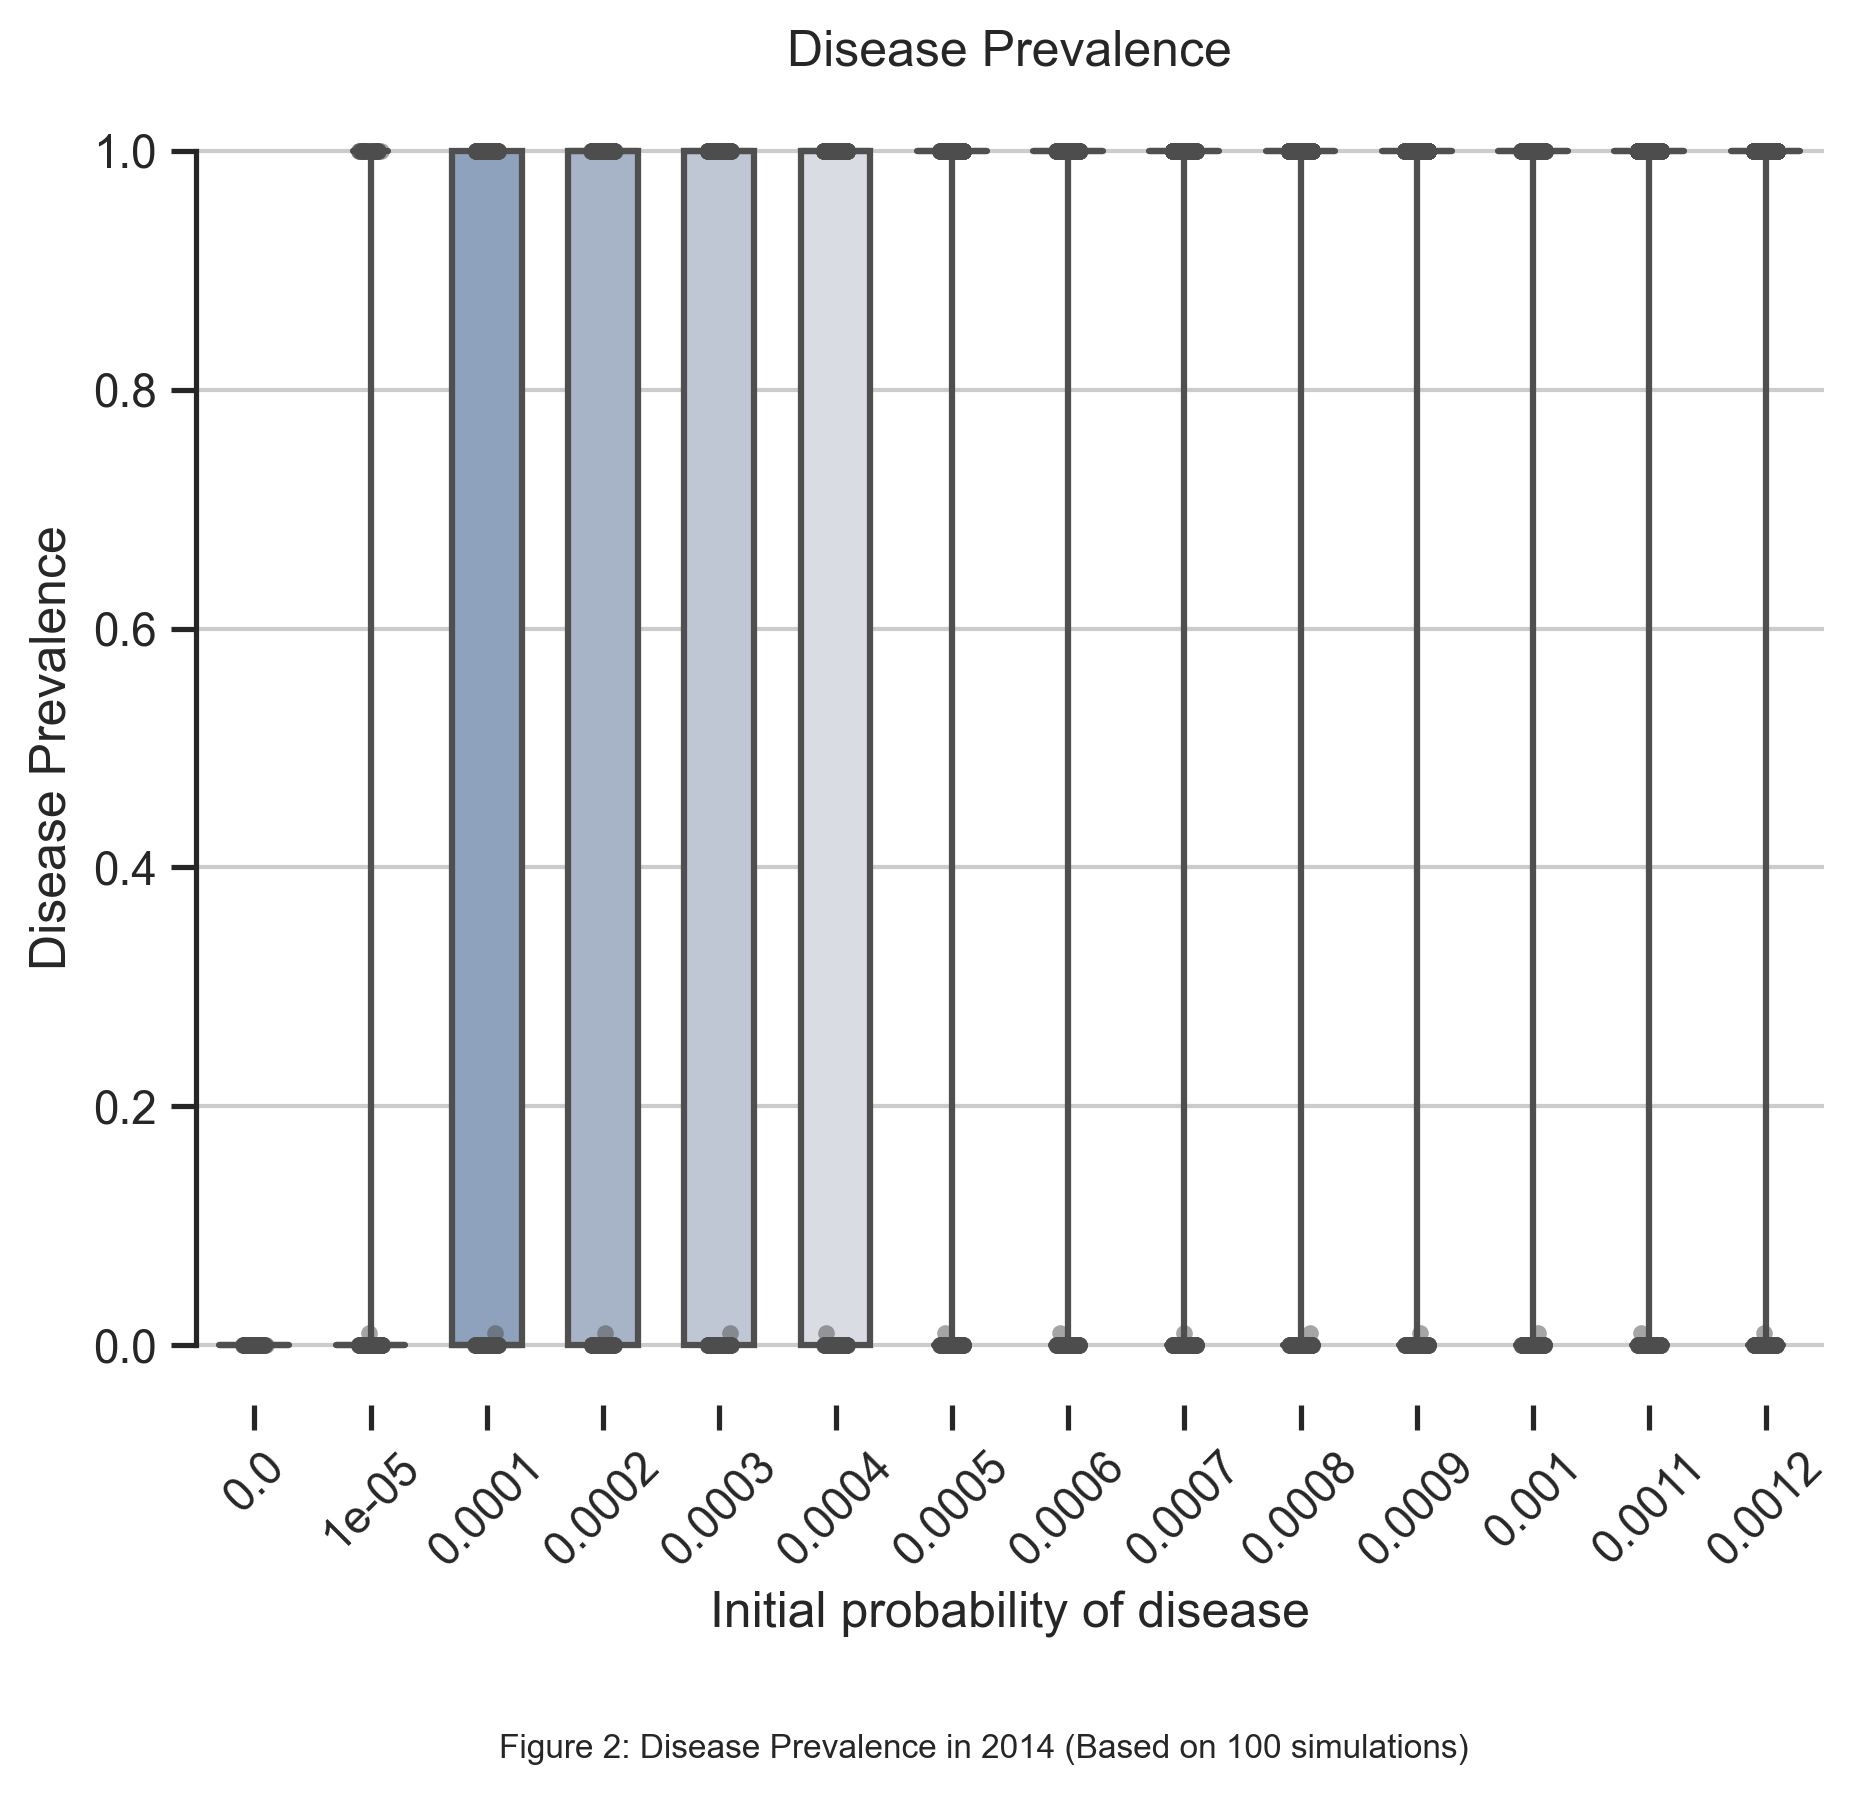

In [2]:
# Create synthetic landscape containing varieties and initial pathogen strains

# Create sI1 containing the indicator on whether source yard is affected by a V6-pathogen strain

# Create constant array of ones to indicate that all yards can be sources for V6-pathogen strain
sI1_lag = np.ones((N, 1))

# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, tI3]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])


# Probability of initial flagshoots
p_values = [0, 0.00001, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012]
#p_values = [0, 0.0005, 0.001]
n = (np.ones((N, 1)) * 400).astype(np.int32)
simulations = 100

y_0_list = []
y_1_list = []
y_2_list = []

disease_prevalence_list = []
disease_incidence_list = []

for p_may in p_values:

    for i in range(simulations):

        # Create y_0, containing the number of initial flagshoots in May
        y_0 = np.random.binomial(n, p_may, size=(N, 1))
        y_0_list.append(y_0)
        
        # Estimate y_1, the number of infections in June
        y_1 = prob(theta_may_jun, period='may-jun', y_lag=y_0) * n
        y_1_list.append(y_1)
        
        # Estimate y_2, the number of infections in July
        y_2 = prob(theta_jun_jul, period='jun-jul', y_lag=y_1) * n
        y_2_list.append(y_2)
        
    y_0_array = np.round(np.array(y_0_list))
    y_1_array = np.round(np.array(y_1_list))
    y_2_array = np.round(np.array(y_2_list))
    
    
    # Calculate disease prevalence and incidence
    disease_prevalence = np.count_nonzero((y_0_array + y_1_array + y_2_array), axis=1) / N
    disease_incidence = (np.mean((y_0_array / n), axis=1) + np.mean((y_1_array / n), axis=1) + np.mean((y_2_array / n), axis=1)) / 3
    
    
    disease_prevalence_list.append(disease_prevalence)
    disease_incidence_list.append(disease_incidence)
    


# Flatten the disease_incidence_list
flat_disease_incidence_list = [item for sublist in disease_incidence_list for item in sublist.ravel()]

# Repeat each p_value based on the number of simulations run for it
p_values_repeated = []
for i in range(len(p_values)):
    p_values_repeated.extend([p_values[i]] * len(disease_incidence_list[i]))

# Check if lengths are the same
assert len(flat_disease_incidence_list) == len(p_values_repeated), \
    f"Lengths do not match: {len(flat_disease_incidence_list)} vs {len(p_values_repeated)}"

# Convert list of arrays into DataFrame
df = pd.DataFrame({
    'p_value': p_values_repeated, 
    'disease_incidence': flat_disease_incidence_list
})

sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot the disease incidence with vertical boxes
sns.boxplot(x='p_value', y='disease_incidence', data=df, whis=[2.5, 97.5], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x='p_value', y='disease_incidence', data=df, size=4, color=".3", linewidth=0, alpha=0.2)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="Initial probability of disease", ylabel="Disease Incidence")
ax.set_title("Disease Incidence")
plt.figtext(0.5, -0.05, f"Figure 1: Disease Incidence in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
sns.despine(trim=True, bottom=True)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()


# Flatten the disease_prevalence_list
flat_disease_prevalence_list = [item for sublist in disease_prevalence_list for item in sublist.ravel()]

# Repeat each p_value based on the number of simulations run for it
p_values_repeated = []
for i in range(len(p_values)):
    p_values_repeated.extend([p_values[i]] * len(disease_prevalence_list[i]))

# Check if lengths are the same
assert len(flat_disease_prevalence_list) == len(p_values_repeated), \
    f"Lengths do not match: {len(flat_disease_prevalence_list)} vs {len(p_values_repeated)}"

# Convert list of arrays into DataFrame
df_prevalence = pd.DataFrame({
    'p_value': p_values_repeated, 
    'disease_prevalence': flat_disease_prevalence_list
})

sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot the disease prevalence with vertical boxes
sns.boxplot(x='p_value', y='disease_prevalence', data=df_prevalence, whis=[2.5, 97.5], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x='p_value', y='disease_prevalence', data=df_prevalence, size=4, color=".3", linewidth=0, alpha=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="Initial probability of disease", ylabel="Disease Prevalence")
sns.despine(trim=True, bottom=True)
ax.set_title("Disease Prevalence")
plt.figtext(0.5, -0.05, f"Figure 2: Disease Prevalence in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

In [6]:
variety_array

array([['mosaic'],
       ['simcoe'],
       ['mosaic'],
       ['nugget'],
       ['mosaic'],
       ['mosaic'],
       ['simcoe'],
       ['mosaic'],
       ['chinook'],
       ['simcoe'],
       ['simcoe'],
       ['simcoe'],
       ['mosaic'],
       ['chinook'],
       ['simcoe'],
       ['chinook'],
       ['nugget'],
       ['simcoe'],
       ['simcoe'],
       ['chinook'],
       ['nugget'],
       ['chinook'],
       ['simcoe'],
       ['simcoe'],
       ['mosaic'],
       ['chinook'],
       ['chinook'],
       ['simcoe'],
       ['simcoe'],
       ['chinook'],
       ['mosaic'],
       ['simcoe'],
       ['mosaic'],
       ['nugget'],
       ['simcoe'],
       ['chinook'],
       ['mosaic'],
       ['chinook'],
       ['mosaic'],
       ['chinook'],
       ['chinook'],
       ['nugget'],
       ['nugget'],
       ['chinook'],
       ['simcoe'],
       ['mosaic'],
       ['simcoe'],
       ['mosaic'],
       ['chinook'],
       ['mosaic'],
       ['nugget'],
       ['chinook'

# Disease prevalence and incidence for each period

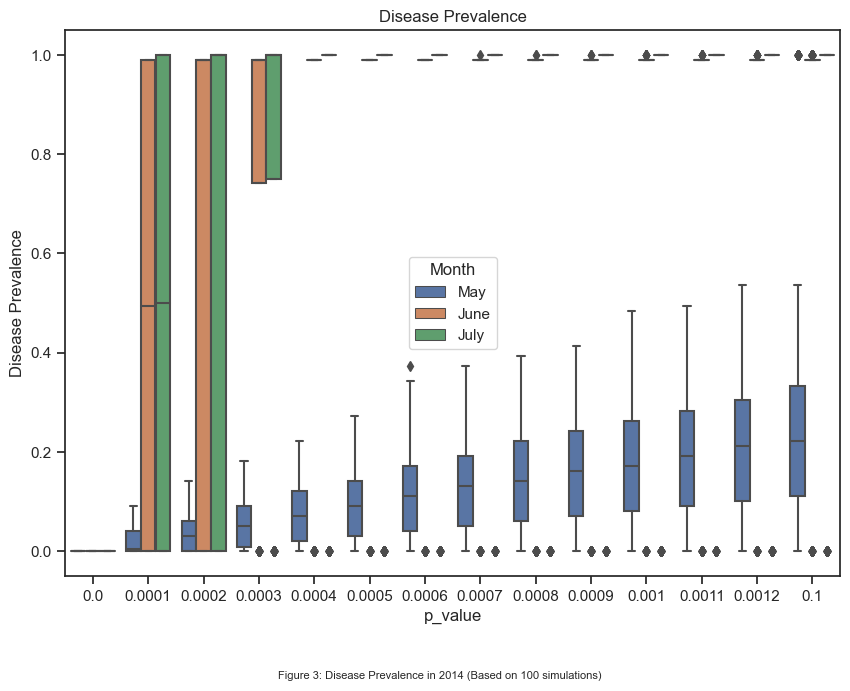

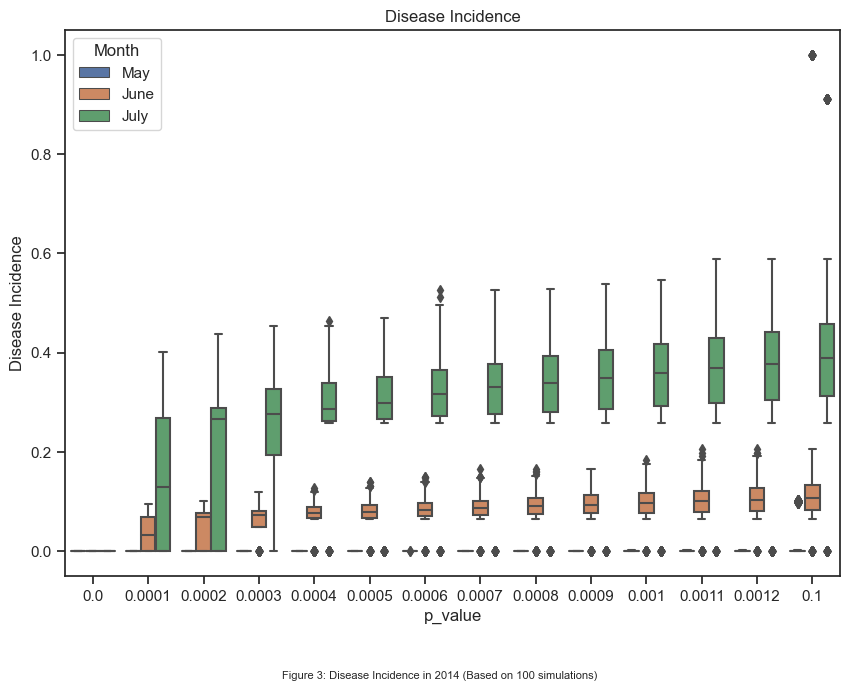

In [4]:
# Create synthetic landscape containing varieties

# Create constant array of ones to indicate that all yards can be sources for V6-pathogen strain
sI1_lag = np.ones((N, 1))

# Create a numpy array of shape (N, 3) with randomly assigned values [0, 1, variety] and [1, 0, variety]
arr = np.zeros((N, 3))

if N % 2 == 0:
    arr[:int(N/2), 0] = 1
    arr[int(N/2):, 1] = 1
    arr[:int(N/4), 2] = 0  # chinook
    arr[int(N/4):int(N/2), 2] = 1  # simcoe
    arr[int(N/2):int(3*N/4), 2] = 2  # mosaic
    arr[int(3*N/4):, 2] = 3  # nugget
else:
    arr[:int((N+1)/2), 0] = 1
    arr[int((N-1)/2):, 1] = 1
    arr[:int((N+1)/4), 2] = 0  # chinook
    arr[int((N+1)/4):int((N+1)/2), 2] = 1  # simcoe
    arr[int((N-1)/2):int((3*N-1)/4), 2] = 2  # mosaic
    arr[int((3*N-1)/4):, 2] = 3  # nugget

# Shuffle the array
np.random.shuffle(arr)

# Split the columns into three (N, 1) arrays
tI1 = arr[:, 0].reshape(N, 1)
tI2 = arr[:, 1].reshape(N, 1)
tI3 = arr[:, 2].reshape(N, 1)

# Create a dictionary for plant varieties
variety_dict = {0: 'chinook', 1: 'simcoe', 2: 'mosaic', 3: 'nugget'}

# Replace plant variety numbers with their names
variety_array = np.vectorize(variety_dict.get)(tI3)

# Create a pandas DataFrame
variety_df = pd.DataFrame(np.hstack([tI1, tI2, tI3]), columns=['Susceptibility1', 'Susceptibility2', 'Variety'])


# Probability of initial flagshoots
p_values = [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0011, 0.0012, 0.1]
n = (np.ones((N, 1)) * 400).astype(np.int32)
simulations = 100

y_0_list = []
y_1_list = []
y_2_list = []

disease_prevalence_list_0 = []
disease_prevalence_list_1 = []
disease_prevalence_list_2 = []

disease_incidence_list_0 = []
disease_incidence_list_1 = []
disease_incidence_list_2 = []

for p_may in p_values:

    for i in range(simulations):

        # Create synthetic initial flagshoot array

        y_0 = np.random.binomial(n, p_may, size=(N, 1))
        y_0_list.append(y_0)
        
        y_1 = np.round(prob(theta_may_jun, period='may-jun', y_lag=y_0) * n)
        y_1_list.append(y_1)
        
        y_2 = np.round(prob(theta_jun_jul, period='jun-jul', y_lag=y_1) * n)
        y_2_list.append(y_2)
        
    y_0_array = np.round(np.array(y_0_list))
    y_1_array = np.round(np.array(y_1_list))
    y_2_array = np.round(np.array(y_2_list))
    
    
    # Calculate disease prevalence and incidence
    disease_prevalence_0 = np.count_nonzero(y_0_array, axis=1) / N
    disease_prevalence_1 = np.count_nonzero(y_1_array, axis=1) / N
    disease_prevalence_2 = np.count_nonzero(y_2_array, axis=1) / N
    
    disease_incidence_0 = np.mean((y_0_array / n), axis=1)
    disease_incidence_1 = np.mean((y_1_array / n), axis=1)
    disease_incidence_2 = np.mean((y_2_array / n), axis=1)
    

    disease_prevalence_list_0.append(disease_prevalence_0)
    disease_prevalence_list_1.append(disease_prevalence_1)
    disease_prevalence_list_2.append(disease_prevalence_2)

    
    disease_incidence_list_0.append(disease_incidence_0)
    disease_incidence_list_1.append(disease_incidence_1)
    disease_incidence_list_2.append(disease_incidence_2)
    


all_data = []
for i, p_may in enumerate(p_values):
    for prevalence_0 in disease_prevalence_list_0[i].flatten():
        all_data.append([p_may, prevalence_0, 'May'])
    for prevalence_1 in disease_prevalence_list_1[i].flatten():
        all_data.append([p_may, prevalence_1, 'June'])
    for prevalence_2 in disease_prevalence_list_2[i].flatten():
        all_data.append([p_may, prevalence_2, 'July'])

# Create a DataFrame
df = pd.DataFrame(all_data, columns=['p_value', 'Disease Prevalence', 'Month'])


# Plotting
plt.figure(figsize=(10, 7))
sns.boxplot(x='p_value', y='Disease Prevalence', hue='Month', data=df)
plt.title('Disease Prevalence')
plt.figtext(0.5, -0.05, f"Figure 3: Disease Prevalence in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
plt.subplots_adjust(bottom=0.1)
plt.show()


all_data = []
for i, p_may in enumerate(p_values):
    for incidence_0 in disease_incidence_list_0[i].flatten():
        all_data.append([p_may, incidence_0, 'May'])
    for incidence_1 in disease_incidence_list_1[i].flatten():
        all_data.append([p_may, incidence_1, 'June'])
    for incidence_2 in disease_incidence_list_2[i].flatten():
        all_data.append([p_may, incidence_2, 'July'])

# Create a DataFrame
df = pd.DataFrame(all_data, columns=['p_value', 'Disease Incidence', 'Month'])


# Plotting
plt.figure(figsize=(10, 7))
sns.boxplot(x='p_value', y='Disease Incidence', hue='Month', data=df)
plt.title('Disease Incidence')
plt.figtext(0.5, -0.05, f"Figure 3: Disease Incidence in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
plt.subplots_adjust(bottom=0.1)
plt.show()

## Summary statistics

### Disease incidence

In [87]:
p_value = 10

n_decimal = 6

print('Initial probability of disease: ', p_values[p_value])

# Print Median disease prevalence

print('Median disease incidence: ', np.round(np.median(disease_incidence_list[p_value]), n_decimal))

# Print min and max of disease prevalence

print('Min disease incidence: ', np.round(np.min(disease_incidence_list[p_value]), n_decimal))
print('Max disease incidence: ', np.round(np.max(disease_incidence_list[p_value]), n_decimal))

# Print 2.5 and 97.5 percentile of disease prevalence
print('2.5 percentile disease incidence: ', np.round(np.percentile(disease_incidence_list[p_value], 2.5), n_decimal))
print('97.5 percentile disease incidence: ', np.round(np.percentile(disease_incidence_list[p_value], 97.5), n_decimal))

Initial probability of disease:  0.001
Median disease incidence:  0.131665
Min disease incidence:  0.0
Max disease incidence:  0.137647
2.5 percentile disease incidence:  0.0
97.5 percentile disease incidence:  0.135281


### Disease prevalence

In [103]:
p_value = 10

print('Initial probability of disease: ', p_values[p_value])

# Print Median disease prevalence

print('Median disease prevalence: ', np.round(np.median(disease_prevalence_list[p_value]), 4))

# Print min and max of disease prevalence

print('Min disease prevalence: ', np.round(np.min(disease_prevalence_list[p_value]), 4))
print('Max disease prevalence: ', np.round(np.max(disease_prevalence_list[p_value]), 4))

# Print 2.5 and 97.5 percentile of disease prevalence
print('2.5 percentile disease prevalence: ', np.round(np.percentile(disease_prevalence_list[p_value], 2.5), 4))
print('97.5 percentile disease prevalence: ', np.round(np.percentile(disease_prevalence_list[p_value], 97.5), 4))

Initial probability of disease:  0.001
Median disease prevalence:  1.0
Min disease prevalence:  0.0
Max disease prevalence:  1.0
2.5 percentile disease prevalence:  0.0
97.5 percentile disease prevalence:  1.0


In [30]:
np.count_nonzero(y_0_array[sim])

4

In [13]:
# Read data from CSV file into a pandas DataFrame
df = pd.read_csv('../data/processed/cost_data.csv', encoding='utf-8')

field_list = []
lat_list = []
long_list = []
mildew_incidence_list = []
grower_list = []
period_list = []

field_id = df.loc[df['Year'] == year, 'Field ID'].unique()

periods = [0, 1, 2]

sim = 201

for period in periods:
    
    for i in range(len(field_id)):
        
        field_list.append(field_id[i])
        lat_list.append(df.loc[df['Field ID'] == field_id[i], 'Centroid Lat'].iloc[0])
        long_list.append(df.loc[df['Field ID'] == field_id[i], 'Centroid Long'].iloc[0])
        grower_list.append(df.loc[df['Field ID'] == field_id[i], 'Grower'].iloc[0])
        period_list.append(period)
        
        if period == 0:
            mildew_incidence_list.append(((y_0_array[sim])/ n)[i][0])
            
        if period == 1:
            mildew_incidence_list.append(((y_1_array[sim]) / n)[i][0])
            
        if period == 2:
            mildew_incidence_list.append(((y_2_array[sim]) / n)[i][0])
            
synthetic_data = {
    "Field ID" : field_list,
    "Period" : period_list,
    "Centroid Lat" : lat_list,
    "Centroid Long" : long_list,
    "Grower" : grower_list,
    "Mildew Incidence" : mildew_incidence_list,
}

synthetic_data = pd.DataFrame(synthetic_data)


# Create map plot

import plotly.express as px
synthetic_data['log_mildew_incidence'] = np.log(synthetic_data['Mildew Incidence'] + 0.0000001)
# calculate log odds from probability
synthetic_data['log_odds'] = np.log(synthetic_data['Mildew Incidence'] / (1 - synthetic_data['Mildew Incidence']) + 1e-10)

fig = px.density_mapbox(synthetic_data, lat='Centroid Lat', lon='Centroid Long', z='Mildew Incidence',
                        hover_name="Field ID", hover_data=["Grower", "Mildew Incidence"],
                        radius=10, zoom=10, height=600,
                        mapbox_style="stamen-terrain",
                        animation_frame="Period", # Add animation_frame parameter
                        color_continuous_scale="thermal", # Add color_continuous_scale parameter, "turbo" is also a good option
                        range_color=[np.min(synthetic_data['Mildew Incidence']), np.max(synthetic_data['Mildew Incidence'])]) # Add range_color parameter

#fig.update_geos(fitbounds="locations")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(title_text="Initial Probability of Infection = 0.0001", margin={"r":0,"t":30,"l":0,"b":0})


print('Number of Fields: ', N)

fig.show()

Number of Fields:  99


# Revenue change

In [1]:
# Data for the estimation of cone incidence vs leaf incidence
df_cone_incidence_leaf_incidence = pd.read_csv('../data/raw/economics/Leaf incidence_vs_Cone_incidence.csv', encoding='utf-8')

# Data preprocessing
df_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.dropna()

# Data for the estimation of yield loss vs cone incidence (change in quantity metric)
df_yield_loss_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_yield_loss_cone_incidence = df_yield_loss_cone_incidence[['Cone incidence', 'Yield Loss']]

# Data for the estimation of cone color vs cone incidence (change in quality metric)
df_cone_color_cone_incidence = pd.read_csv('../data/raw/economics/Cone incidence_vs_Cone color_and_Yield.csv', encoding='utf-8')
df_cone_color_cone_incidence = df_cone_color_cone_incidence[['Cone incidence', 'Cone Color']]


# Data
data_cone_incidence_leaf_incidence = df_cone_incidence_leaf_incidence.to_numpy()
data_yield_loss_cone_incidence = df_yield_loss_cone_incidence.to_numpy()
data_cone_color_cone_incidence = df_cone_color_cone_incidence.to_numpy()

# Regressions

# CONE INCIDENCE VS LEAF INCIDENCE
a1, b1 = np.polyfit(data_cone_incidence_leaf_incidence[:, 0], data_cone_incidence_leaf_incidence[:, 1], 1)

# YIELD LOSS VS CONE INCIDENCE
a2, b2 = np.polyfit(data_yield_loss_cone_incidence[:, 0], data_yield_loss_cone_incidence[:, 1], 1)

# CONE COLOR VS CONE INCIDENCE
# Define the exponential decay function that passes through (0, 10)
def exp_decreasing(x, a3, b3):
    return 10 + a3 * (1 - np.exp(-b3 * x))

# Provide an initial guess for the parameters
initial_guess = [1, 1]

# Fit the exponential decay model to the data, with an increased max number of function evaluations
params, _ = curve_fit(exp_decreasing, data_cone_color_cone_incidence[:, 0], data_cone_color_cone_incidence[:, 1], p0=initial_guess, maxfev=5000)

a3, b3 = params


# Load parameters
checkpoint1 = np.load('../reports/checkpoint_high_demand.npy', allow_pickle=True)
theta_high = checkpoint1[0]

checkpoint2 = np.load('../reports/checkpoint_moderate_demand.npy', allow_pickle=True)
theta_moderate = checkpoint2[0]

checkpoint3 = np.load('../reports/checkpoint_low_demand.npy', allow_pickle=True)
theta_low = checkpoint3[0]

# Define logistic sigmoid function
def sigmoid(z):

    g = 1 / (1 + np.exp(-z))
    
    return g

# QUALITY METRIC
# Function to estimate cone color given plant incidence
def cone_color(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    # intercept fixed at 10 since that's the highest cone color rating
    cone_color = 10 + a3 * (1 - np.exp(-b3 * cone_incidence))
    
    return cone_color

# QUANTITY METRIC
# Function to estimate yield loss given plant incidence (probability of disease in plants)
def yield_loss(plant_incidence, n=100, D=1.19):
    
    # n is the number of leaves sampled and D is the index of dispersion
    n_D = n / D 
    
    leaf_incidence = 1 - (1 - plant_incidence) ** (1 / n_D)
    
    cone_incidence = a1 * leaf_incidence + b1
    
    yield_loss = a2 * cone_incidence
    
    return yield_loss


# Function to estimate revenue and revenue change given plant incidence
def revenue(plant_incidence, n=100, D=1.19, demand="high", variety="nugget"):
    
    if variety == "nugget":
        initial_yield = 2038.0
        initial_price = [2.5, 4.25, 6.0] #[low, mod, high] demand
        
    elif variety == "chinook":
        initial_yield = 1629.3333
        initial_price = [4.0, 5.0, 6.5]
        
    elif variety == "simcoe":
        initial_yield = 1752.0
        initial_price = [5.0, 6.5, 8.0]
        
    elif variety == "mosaic":
        initial_yield = 2134.0
        initial_price = [5.0, 6.5, 8.0]
        
    
    adjusted_yield = initial_yield * (1 - yield_loss(plant_incidence, n, D))
    
    if demand == "low":
        
        adjusted_price = initial_price[0] * sigmoid(theta_low[0] + theta_low[1] * cone_color(plant_incidence, n, D))
        adjusted_yield = initial_yield * (1 - yield_loss(plant_incidence, n, D))
        revenue = initial_price[0] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        revenue_change = (adjusted_revenue - revenue) / revenue
    
    elif demand == "moderate":
        
        adjusted_price = initial_price[1] * sigmoid(theta_moderate[0] + theta_moderate[1] * cone_color(plant_incidence, n, D))
        revenue = initial_price[1] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        revenue_change = (adjusted_revenue - revenue) / revenue
        
    elif demand == "high":
        
        adjusted_price = initial_price[2] * sigmoid(theta_high[0] + theta_high[1] * cone_color(plant_incidence, n, D))
        revenue = initial_price[2] * initial_yield
        adjusted_revenue = adjusted_price * adjusted_yield
        revenue_change = (adjusted_revenue - revenue) / revenue
        
    return adjusted_revenue, revenue_change

NameError: name 'pd' is not defined

In [15]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

# Assuming you have already defined revenue(), sigmoid(), and yield_loss() functions from earlier

def plot_revenue_vs_color(plant_incidence, n, D):
    colors = np.arange(1, 11, 1) # integer values from 1 to 10
    
    # Calculate revenues for each demand type
    revenues_low = [revenue(plant_incidence, color, n, D, demand="low", variety="nugget")[0] for color in colors]
    revenues_mod = [revenue(plant_incidence, color, n, D, demand="moderate", variety="nugget")[0] for color in colors]
    revenues_high = [revenue(plant_incidence, color, n, D, demand="high", variety="nugget")[0] for color in colors]
    
    plt.figure(figsize=(10,6))
    plt.plot(colors, revenues_low, '-o', label='Adjusted Revenue (Low Demand)')
    plt.plot(colors, revenues_mod, '-s', label='Adjusted Revenue (Moderate Demand)')
    plt.plot(colors, revenues_high, '-^', label='Adjusted Revenue (High Demand)')
    plt.xlabel('Cone Color Value')
    plt.ylabel('Adjusted Revenue')
    plt.title('Adjusted Revenue vs Cone Color Value for Different Demand Levels')
    plt.grid(True)
    
    # Set the y-axis range, x-axis ticks, and legend position
    plt.ylim(0, 13000)
    plt.xticks(colors)  # x-axis ticks for each color value
    plt.legend(loc="upper left")  # legend positioned at the top left
    
    plt.show()

widgets.interact(plot_revenue_vs_color, 
                 plant_incidence=widgets.FloatSlider(value=0.5, min=0, max=1, step=0.01, description='Plant Incidence'),
                 n=widgets.IntSlider(value=100, min=1, max=1000, step=1, description='n'),
                 D=widgets.FloatSlider(value=1.19, min=0, max=2, step=0.01, description='D')
                )


interactive(children=(FloatSlider(value=0.5, description='Plant Incidence', max=1.0, step=0.01), IntSlider(val…

<function __main__.plot_revenue_vs_color(plant_incidence, n, D)>

In [12]:
revenue(plant_incidence=0, n=100, D=1.19, demand="high", variety="simcoe")[1]

-0.00536959640920446

1400


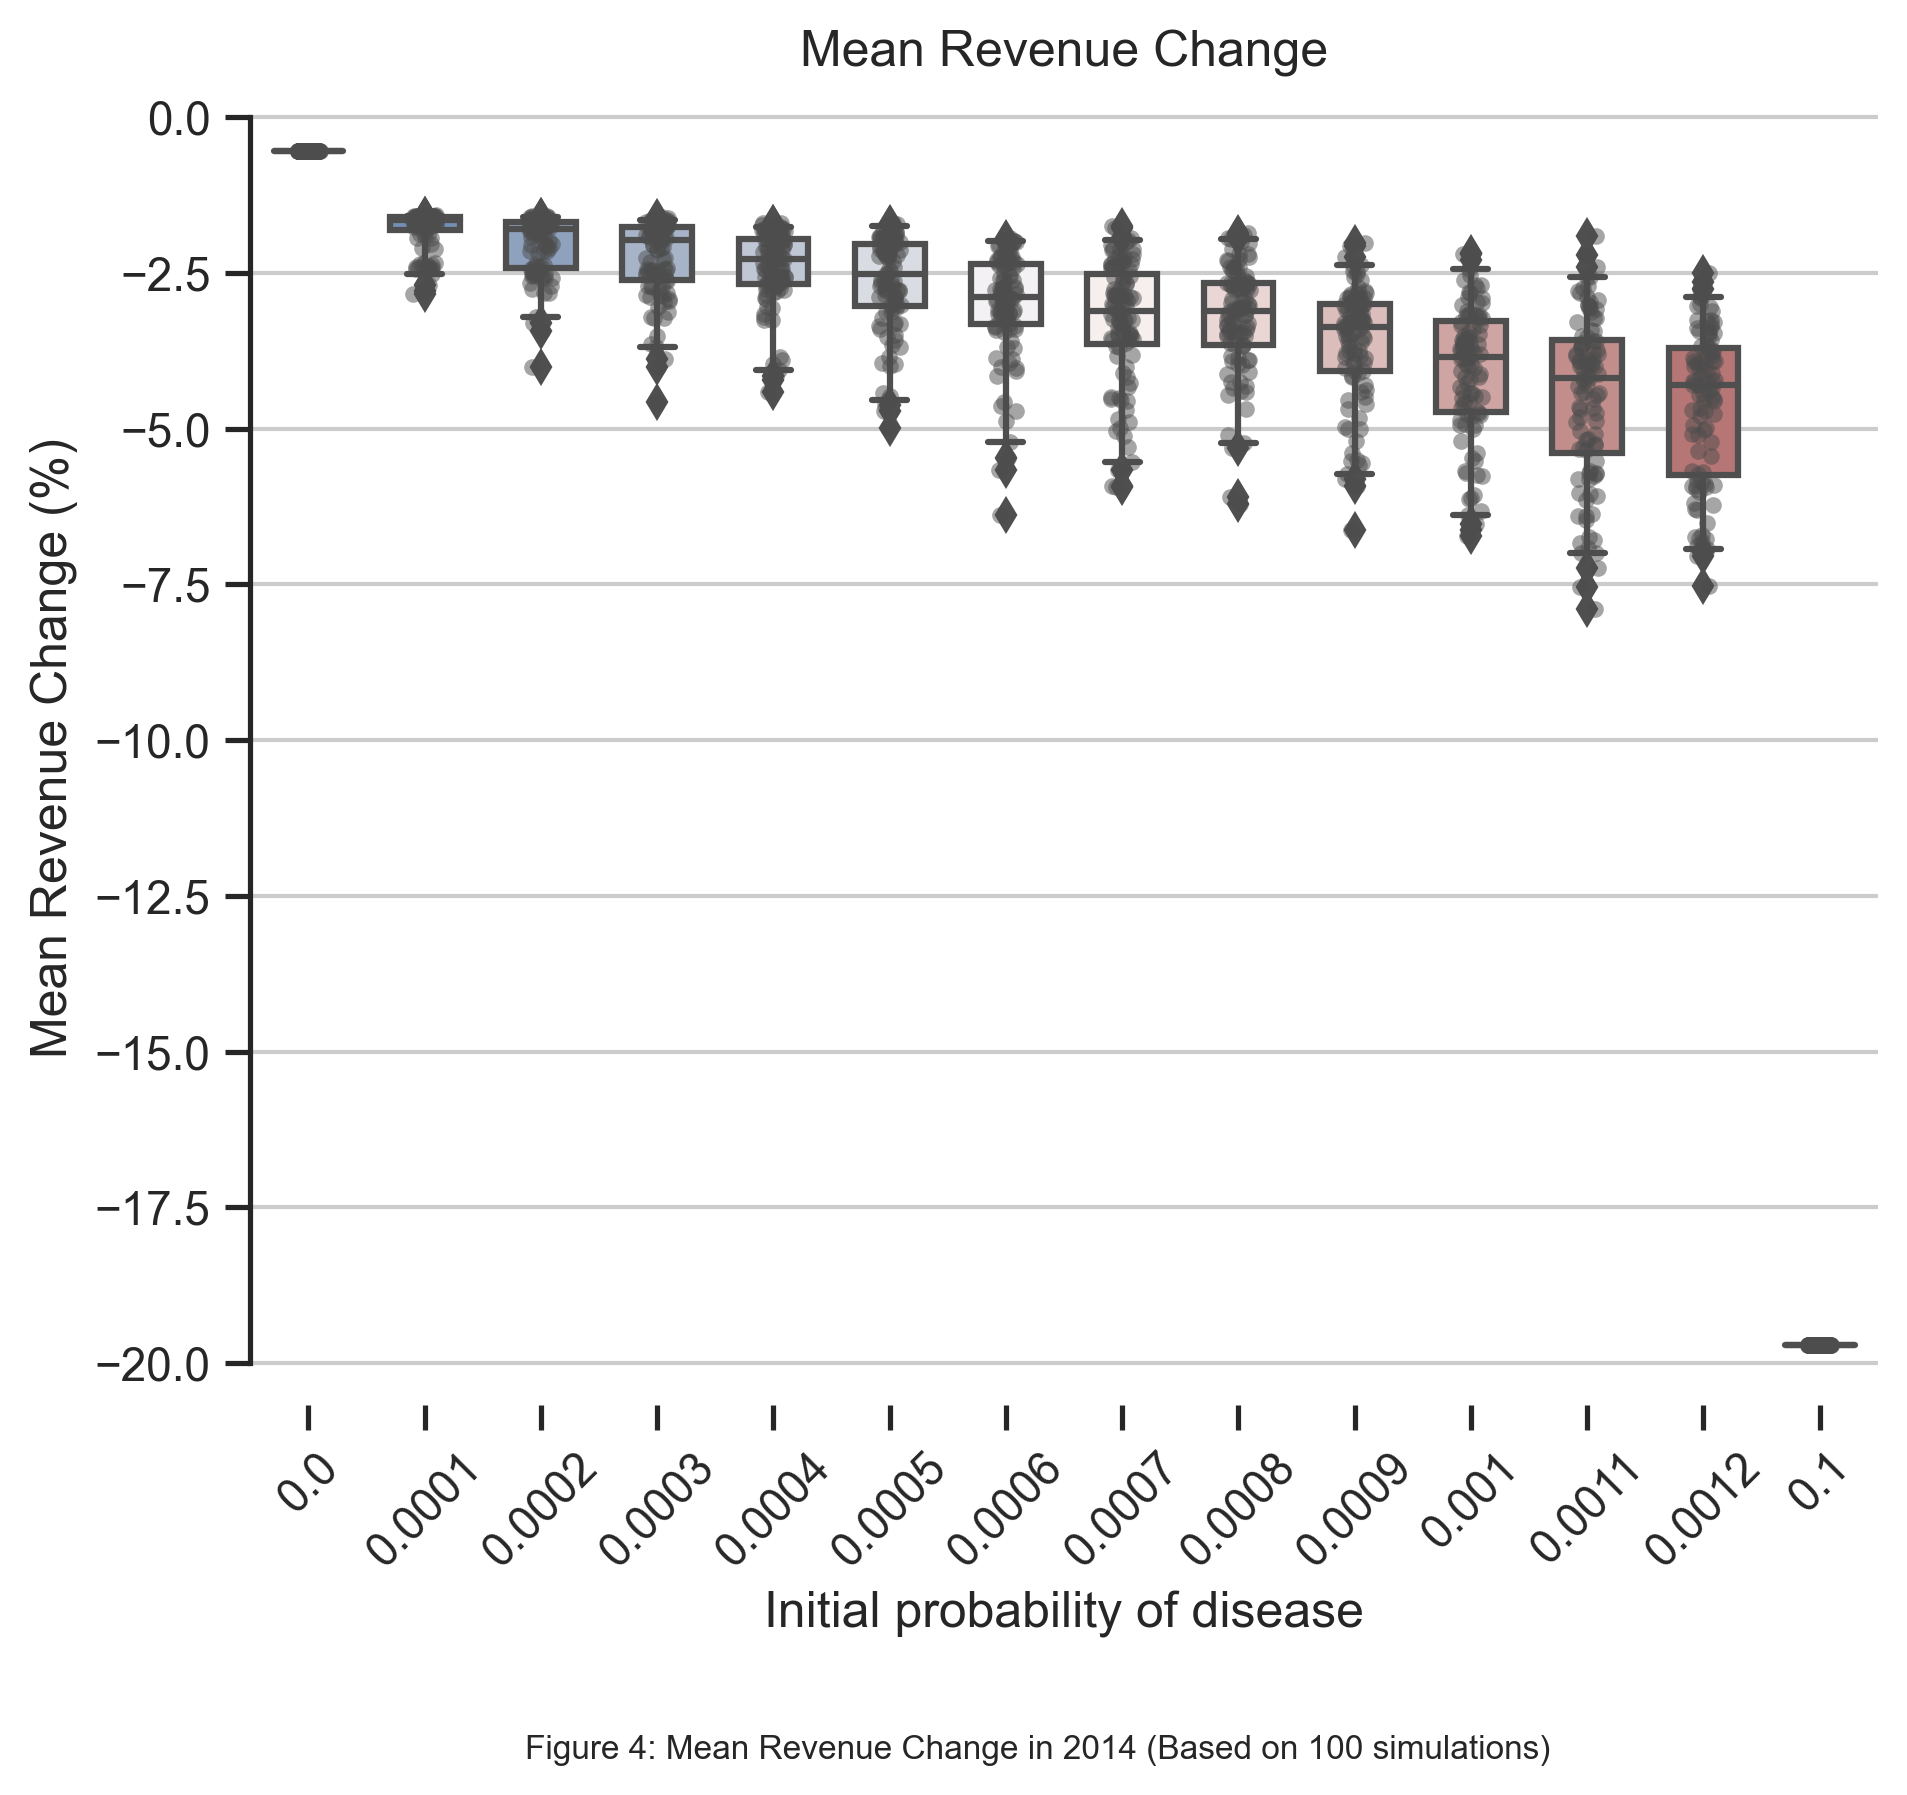

In [19]:
revenue_change_simulations_list = []

for simulation in range(0, simulations * len(p_values)):

    revenue_change_list = []

    for field in range(0, N):
        
        revenue_change = revenue((y_2_array[simulation][field] / n[field]), n=10, D=1.19, demand="high", variety=variety_array[field][0])[1]
        revenue_change_list.append(revenue_change)
        
    revenue_change_array = np.array(revenue_change_list).reshape(N, 1)
    revenue_change_simulations_list.append(revenue_change_array)
    
mean_revenue_change_simulations_list = np.mean(revenue_change_simulations_list, axis=1) * 100

# Plot Mean of Revenue Change Simulations List

# Flatten the mean_revenue_change_simulations_list
flat_mean_revenue_change_simulations_list = [item for sublist in mean_revenue_change_simulations_list for item in sublist.ravel()]

# Repeat each p_value based on the number of simulations run for it
p_values_repeated = []
for i in range(len(p_values)):
    p_values_repeated.extend([p_values[i]] * len(mean_revenue_change_simulations_list[i]) * simulations)
print(len(p_values_repeated))
# Check if lengths are the same
assert len(flat_mean_revenue_change_simulations_list) == len(p_values_repeated), \
    f"Lengths do not match: {len(flat_mean_revenue_change_simulations_list)} vs {len(p_values_repeated)}"
    
# Convert list of arrays into DataFrame
df_revenue_change = pd.DataFrame({
    'p_value': p_values_repeated, 
    'mean_revenue_change': flat_mean_revenue_change_simulations_list
})

sns.set_theme(style="ticks")

# Initialize the figure
f, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot the disease prevalence with vertical boxes
sns.boxplot(x='p_value', y='mean_revenue_change', data=df_revenue_change, whis=[2.5, 97.5], width=.6, palette="vlag")

# Add in points to show each observation
sns.stripplot(x='p_value', y='mean_revenue_change', data=df_revenue_change, size=4, color=".3", linewidth=0, alpha=0.5)

# Tweak the visual presentation
ax.yaxis.grid(True)
ax.set(xlabel="Initial probability of disease", ylabel="Mean Revenue Change (%)")
sns.despine(trim=True, bottom=True)
ax.set_title("Mean Revenue Change")
plt.figtext(0.5, -0.05, f"Figure 4: Mean Revenue Change in {year} (Based on {simulations} simulations)", ha="center", fontsize=8, va="bottom")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()
